## Description
Many earth observation datasets are available at regular intervals over long periods of time. This enables us to detect changes on the Earth’s surface. In this session, you will learn how to apply change detection technique in remote sensing.

## Aims of the practical session
* Create ROI and load it
* Collect images and training samples
* Apply classification algorithms to classify images before and after an event
* Comparing two classified images to see the changes during the time

## Getting started

### Load packages

Import GEE packages that are needed for the analysis.

In [1]:
import ee
import geemap
# ee.Authenticate()

### Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [2]:
import geemap
Map = geemap.Map()
# Map.add_basemap('HYBRID')
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

### Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map.
Import the downloaded shapefile for Canberra central from your computer path as ROI.

In [3]:
# # # load shapefile (ROI)
shp_path = 'D:/GEE Tutorials/NOV21_ACT_LOC_POLYGON_shp/Canberra_central.shp'
geometry = geemap.shp_to_ee(shp_path)
Map.addLayer(geometry, {}, 'Canberra central SHP')
Map.centerObject(geometry);

C:\Users\Abolfazl\Anaconda3\envs\gee\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Training data
Training data (or a training dataset) is the initial data used to train machine learning models. Import your pre-selected training dataset from your system.

In [4]:
#### load training data
trainingS_path = 'C:/Users/Abolfazl/Desktop/code/Google Earth Engine/training_data.shp'
training_data = geemap.shp_to_ee(trainingS_path)
Map.addLayer(training_data, {}, 'training_data')
Map.centerObject(training_data)

C:\Users\Abolfazl\Anaconda3\envs\gee\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Before Image collection 
An ImageCollection is a stack or sequence of images. An ImageCollection can be loaded by pasting an Earth Engine asset ID into the ImageCollection constructor. You can find ImageCollection IDs in the <a href="https://developers.google.com/earth-engine/datasets">data catalog</a>. 

We will:
* Load before Landsat-8 images for the anlysis
* Filter a collection by date range
* Make a cloud-free composite 

In [5]:
# # Make a cloud-free Landsat 8 TOA composite (Before imagery).
landsatCollectionB = ee.ImageCollection('LANDSAT/LC08/C01/T1') \
    .filterDate('2015-03-01', '2015-03-31')\
    .filterBounds(geometry)
    #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    #.sort('CLOUD_COVER')
    #.first()

In [6]:
print(landsatCollectionB.size().getInfo());

4


In [7]:
# # # Use these bands for prediction.
bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11']

### Make a cloud-free composite
Computes a Landsat TOA composite from a collection of raw Landsat scenes. It applies standard TOA calibration and then assigns a cloud score to each pixel using the SimpleLandsatCloudScore algorithm. It selects the lowest possible range of cloud scores at each point and then computes per-band percentile values from the accepted pixels. This algorithm also uses the LandsatPathRowLimit algorithm to select only the least-cloudy scenes in regions where more than maxDepth input scenes are available. More information can be found <a href="https://developers.google.com/earth-engine/apidocs/ee-algorithms-landsat-simplecomposite">simpleComposite</a>. 

In [8]:
# Make a cloud-free composite.
compositeB = ee.Algorithms.Landsat.simpleComposite(**{
  'collection': landsatCollectionB,
  'asFloat': True
})

### Visualize the composite
* Clip based on the geometry
* Display it on Geemap

In [9]:
# Visualize the Composite
compositeB = compositeB.clip(geometry).select(bands)
Map.addLayer(compositeB, {'bands': ['B4',  'B3',  'B2'], 'max': 0.5, 'gamma': 2}, 'L8 Image Before', True)
Map

Map(bottom=20298425.0, center=[-35.17380831799957, 149.06250000000003], controls=(WidgetControl(options=['posi…

### Overlay the point on the image to get training data
Now that we have created the points and labels, we need to sample the imagery using image.sampleRegions(). This command will extract the reflectance in the designated bands for each of the points you have created. 

In [10]:
# Overlay the point on the image to get training data.
training = compositeB.sampleRegions(**{
  'collection': training_data,
  'properties': ['landcover'],
  'scale': 30
})

### Classifcation method
The <a href="https://developers.google.com/earth-engine/guides/classification">Classifier</a> package in handles supervised classification by ML algorithms running in Earth Engine. Thus, in this part we will:
* Instantiate a supervised classifier
* Set its parameters if necessary
* Train the classifier using the training data
* Classify an image or feature collection
* Display the classified map

In [11]:
# Train a classifier.
classifier = ee.Classifier.smileRandomForest(50).train(**{
  'features': training,
  'classProperty': 'landcover',
  'inputProperties': compositeB.bandNames()
})

In [12]:
# # Classify the image.
beforeClassified = compositeB.classify(classifier)
Map.addLayer(beforeClassified,{'min': 0, 'max': 3, 'palette': ['blue', 'green', 'yellow', 'red']}, 'before_classified')
Map

Map(bottom=20298425.0, center=[-35.17380831799957, 149.06250000000003], controls=(WidgetControl(options=['posi…

### After Image collection 
We will:
* Load after Landsat-8 images for the anlysis
* Filter a collection by date range
* Make a cloud-free composite 

In [13]:
# # After Images.
landsatCollectionA = ee.ImageCollection('LANDSAT/LC08/C01/T1') \
    .filterDate('2021-03-01', '2021-03-31') \
    .filterBounds(geometry)
    #.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    #.sort('CLOUD_COVER')
    #.first()

In [14]:
print(landsatCollectionB.size().getInfo());

4


### Make a cloud-free composite
Use SimpleLandsatCloudScore algorithm to computes a Landsat TOA composite from a collection of raw Landsat scenes. It applies standard TOA calibration and then assigns a cloud score to each pixel. More information can be found <a href="https://developers.google.com/earth-engine/apidocs/ee-algorithms-landsat-simplecomposite">simpleComposite</a>. 

In [15]:
# Make a cloud-free composite.
compositeA = ee.Algorithms.Landsat.simpleComposite(**{
  'collection': landsatCollectionA,
  'asFloat': True
})

### Visualize the composite
* Clip based on the geometry
* Display it on Geemap

In [16]:
# Visualize the Composite
compositeA = compositeA.clip(geometry).select(bands)
Map.addLayer(compositeA, {'bands': ['B4',  'B3',  'B2'], 'max': 0.5, 'gamma': 2}, 'L8 Image After', True)
Map

Map(bottom=20298425.0, center=[-35.17380831799957, 149.06250000000003], controls=(WidgetControl(options=['posi…

### Classify the image
* Apply the same supervised classifier on after image
* Classify an image or feature collection
* Display the classified map

In [17]:
# Classify the image.
afterClassified= compositeA.classify(classifier)
Map.addLayer(afterClassified,{'min': 0, 'max': 3, 'palette': ['blue', 'green', 'yellow', 'red']}, 'after_classified')
Map

Map(bottom=20298425.0, center=[-35.17380831799957, 149.06250000000003], controls=(WidgetControl(options=['posi…

### <a name="ex3"></a> Challenge

<div class="alert alert-block alert-danger">

- Try to calculate the accuracy of the method for both pre and post-classifcation results to see if the performance of the model is satisfactory. 
    
    
</div> 

In [18]:
# Reclassify from 0-3 to 1-4
beforeClasses = beforeClassified.remap([0, 1, 2, 3], [1, 2, 3, 4])
afterClasses = afterClassified.remap([0, 1, 2, 3], [1, 2, 3, 4])

### Post-classification comparison
We dealing with multi-class images, a useful metric for change detection is to know how many pixels from class X changed to class Y. 

In [19]:
# Show all changed areas
changed = afterClasses.subtract(beforeClasses).neq(0)
Map.addLayer(changed, {'min':0, 'max':1, 'palette': ['white', 'red']}, 'Change')
Map

Map(bottom=20298425.0, center=[-35.17380831799957, 149.06250000000003], controls=(WidgetControl(options=['posi…

<span style='background:yellow'> <span style="font-size:16.0pt"> Exercise  </span>

### Exercise 1 - Calculate area by each transition class 
Try to add the before image with the after image to represent each unique transition of pixel values

#### Then try to check the following exercises:
* Calculate the area of each class transition?
* You can use a grouped reducer
* Show all areas where each class became other class and display the result
* Post-process the result to generate a clean output

## References
This is where the references go. For exmaple:

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305
* "Earth Observation: Data, Processing and Applications" book. Available through Wattle, or http://www.crcsi.com.au/earth-observation-series.

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site.

**Last modified:** June 2022

### Exercise answers

<a name="ex1answer">Answer to Exercise 1</a>

In [20]:
# # We multiply the before image with 100 and add the after image
# # The resulting pixel values will be unique and will represent each unique transition
# merged = beforeClasses.multiply(100).add(afterClasses).rename('transitions')

In [21]:
# # Calculate Area by each Transition Class
# # using a Grouped Reducer
# # Divide by 1e6 to get the area in sq.km.
# areaImage = ee.Image.pixelArea().divide(1e6).addBands(merged)

# areas = areaImage.reduceRegion(**{
#       'reducer': ee.Reducer.sum().group(**{
#       'groupField': 1,
#       'groupName': 'transitions',
#     }),
#     'geometry': geometry,
#     'scale': 30,
#     'maxPixels': 1e9
#     })

In [22]:
# # Post-process the result to generate a clean output
# classAreas = ee.List(areas.get('groups'))

# def cleanOutput(item):
#       areaDict = ee.Dictionary(item)
#       classNumber = ee.Number(areaDict.get('transitions')).format()
#       area = ee.Number(areaDict.get('sum')).round()
#       return ee.List([classNumber, area])

# classAreaLists = classAreas.map(cleanOutput)

# classTransitionsAreaDict = ee.Dictionary(classAreaLists.flatten())
# print(classTransitionsAreaDict.getInfo())

{'101': 28, '102': 0, '103': 1, '104': 0, '201': 9, '202': 6, '203': 2, '204': 0, '301': 15, '302': 2, '303': 19, '304': 0, '401': 0, '402': 0, '403': 0, '404': 6}


In [23]:
# ## Plot the results
# import matplotlib.pyplot as plt

# import pandas as pd

# my_dict = {'101': 28, '102': 0, '103': 1, '104': 0, '201': 9, '202': 6, '203': 2, '204': 0, '301': 15, '302': 2, '303': 19,
#            '304': 0, '401': 0, '402': 0, '403': 0, '404': 6}
# df = pd.DataFrame(list(my_dict.items()),columns = ['Transition','Area'])

# print (df)
# print (type(df))

   Transition  Area
0         101    28
1         102     0
2         103     1
3         104     0
4         201     9
5         202     6
6         203     2
7         204     0
8         301    15
9         302     2
10        303    19
11        304     0
12        401     0
13        402     0
14        403     0
15        404     6
<class 'pandas.core.frame.DataFrame'>


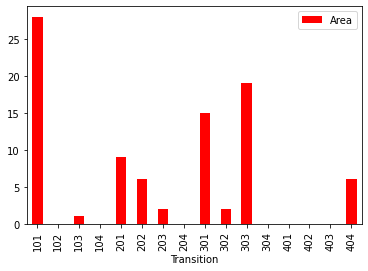

In [24]:
# # a scatter plot comparing num_children and num_pets
# df.plot(kind='bar',x='Transition',y='Area',color='red')
# plt.show()